In [1]:
import pandas as pd
import uproot3
from functools import reduce
import struct
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors

## Requires lbtools,
#from lb2jpsil import categorize_reconstructed

# Functions for importing

In [2]:
def get_final_state():
    final_state = {
        'L'      : ['p', 'pim'],
        'Lb'     : ['p', 'pim', 'mum', 'mup'],
        'KS0'    : ['pip', 'pim'],
        'B0'     : ['pip', 'pim', 'mum', 'mup'],
        }
    return final_state


def generate_MCTRUTH_mapping(mother):
    final_state = get_final_state()
    intermediate = { 
        'L'     : [],
        'KS0'   : [],
        'Lb'    : ['L'],
        'B0'    : ['KS0'],
        }
    mapper = {}
    mapper.update({ part + '_TRUEENDVERTEX_' + coord : 'MCTRUTH_' + part + '_ENDVERTEX_' + coord for part in [mother] + intermediate[mother] for coord in ['X', 'Y', 'Z'] })
    mapper.update({ part + '_TRUEP_' + coord  : 'MCTRUTH_' + part + '_P' + coord for part in final_state[mother] for coord in ['X', 'Y', 'Z'] })
    if intermediate[mother]:
        mapper[f'{intermediate[mother][0]}_MC_MOTHER_ID'] = f'MCTRUTH_{mother}_ID'
        mapper['pim_MC_MOTHER_ID'] = f'MCTRUTH_{intermediate[mother][0]}_ID'
    else:
        mapper[f'{final_state[mother]}_MC_MOTHER_ID'] = f'MCTRUTH_{mother}_ID'
    return mapper

In [3]:
def GetRecoTree(inputMC):
    df_reco_list = []

    with uproot3.open(inputMC) as MCFile:
        tree_reco = MCFile['Lb_T/DecayTree']
        branches = [k.decode('utf-8') for k in tree_reco.keys()]

    #    for particle in ['mum', 'mup', 'p', 'pim']:
    #        df_reco_list.append(tree_reco.pandas.df(particle + "_PP_POSMOMCOV*", flatten=True))

    #    df_reco_list.append(tree_reco.pandas.df(["*_Reconstructible", "*_Reconstructed"] + list(generate_MCTRUTH_mapping('Lb').keys()), flatten=True))
        df_reco_list.append(tree_reco.pandas.df(list(generate_MCTRUTH_mapping('Lb').keys()), flatten=True))

    df_reco = reduce(lambda left,right: pd.merge(left, right, left_index=True, right_index=True), df_reco_list)
    del(df_reco_list)

    #df_reco.reset_index(level=1, drop=True, inplace=True)
    df_reco['TrackType'] = 'T'
    
    return df_reco

def GetTruthTree(inputMC):
    df_truth_list = []

    with uproot3.open(inputMC) as MCFile:
        tree_truth = MCFile['Lb_MC/MCDecayTree']
        branches = [k.decode('utf-8') for k in tree_truth.keys()]

        for particle in ['mum', 'mup', 'p', 'pim']:
            df_truth_list.append(tree_truth.pandas.df(particle + "_PP_POSMOMCOV*", flatten=True))

        df_truth_list.append(tree_truth.pandas.df(["*_Reconstructible", "*_Reconstructed"] + list(generate_MCTRUTH_mapping('Lb').keys()), flatten=True))


    df_truth = reduce(lambda left,right: pd.merge(left, right, left_index=True, right_index=True), df_truth_list)
    del(df_truth_list)

    df_truth.reset_index(level=1, drop=True, inplace=True)
    return df_truth

In [4]:
def MergeRecoTruth(df_reco, df_truth):
    MCTRUTH_mapping = generate_MCTRUTH_mapping('Lb')
    columns_for_long_key = [b for b in MCTRUTH_mapping.keys() if 'TRUEID' not in b]
    
    df_reco['MC_longkey'] = df_reco.loc[:, columns_for_long_key].agg(lambda x : struct.pack('f' * len(columns_for_long_key), *x), axis='columns')
    df_truth['MC_longkey'] = df_truth.loc[:, columns_for_long_key].agg(lambda x : struct.pack('f' * len(columns_for_long_key), *x), axis='columns')
    
    df_truth['MC_key'] = df_truth.index
    df_reco['Rec_key'] = df_reco.index
    
    df_reco = pd.merge(df_reco, df_truth.loc[:, ['MC_longkey', 'MC_key']], on='MC_longkey', how='left')
    df_reco_grouped = df_reco.loc[:, ['MC_longkey', 'Rec_key', 'TrackType']].groupby('MC_longkey').agg({'Rec_key' : ['min', 'count'], 'TrackType' : ['first']}).reset_index()
    df_reco_grouped.columns = ['MC_longkey', 'Rec_key', 'N_rec_matches', 'TrackType']
    
    df_truth = pd.merge(df_truth, df_reco_grouped, on='MC_longkey', how='left')
    
    df_reco.drop('MC_longkey', inplace=True, axis='columns')
    df_truth.drop('MC_longkey', inplace=True, axis='columns')
    
    frac_reco_match_gen = (~df_reco['MC_key'].isna()).sum() / len(df_reco) * 100
    #print(f'The fraction of the reconstructed candidates with full match in the generated sample is {frac_reco_match_gen:.2f}%')

    frac_gen_match_reco = (~df_truth['Rec_key'].isna()).sum() / len(df_truth) * 100
    #print(f'The fraction of the generated signal events with full match in the reconstructed sample is {frac_gen_match_reco:.2f}%')
    
    df_reco.index.name = 'Rec_key'
    df_reco.drop('Rec_key', inplace=True, axis='columns')
    df_truth.index.name = 'MC_key'
    df_truth.drop('MC_key', inplace=True, axis='columns')
    
    df_reco['MC_key'] = pd.to_numeric(df_reco['MC_key'].fillna(-1), downcast='signed')
    df_truth['Rec_key'] = pd.to_numeric(df_truth['Rec_key'].fillna(-1), downcast='signed')
    df_truth['N_rec_matches'] = pd.to_numeric(df_truth['N_rec_matches'].fillna(0), downcast='unsigned')
    
    df_reco.drop(columns=MCTRUTH_mapping.keys(), inplace=True)
    df_truth.rename(columns=MCTRUTH_mapping, inplace=True)
    
    df_MC = pd.merge(df_truth, df_reco.loc[df_reco['MC_key'] >= 0, :].drop('TrackType', axis='columns').groupby('MC_key').first(), how='left', on='MC_key')
    
    return df_MC

# Import Monte Carlo data

In [5]:
fileList = [
    '~/data/raw_MC/0/output/Lb2JPsiL_Run2_Sim_2016_MagUp_v12.root',
    '~/data/raw_MC/1/output/Lb2JPsiL_Run2_Sim_2016_MagUp_v12.root',
    '~/data/raw_MC/2/output/Lb2JPsiL_Run2_Sim_2016_MagUp_v12.root',
    '~/data/raw_MC/3/output/Lb2JPsiL_Run2_Sim_2016_MagUp_v12.root',
    '~/data/raw_MC/4/output/Lb2JPsiL_Run2_Sim_2016_MagUp_v12.root',
    '~/data/raw_MC/5/output/Lb2JPsiL_Run2_Sim_2016_MagUp_v12.root',
]

In [6]:
dfList = []

for inputFile in fileList:
    df_reco = GetRecoTree(inputFile)
    df_truth = GetTruthTree(inputFile)
    df_MC_temp = MergeRecoTruth(df_reco, df_truth)
    dfList.append(df_MC_temp)

In [7]:
df_MC = pd.concat(dfList, ignore_index=True)
df_MC

,mum_PP_POSMOMCOV_0_0,mum_PP_POSMOMCOV_0_1,mum_PP_POSMOMCOV_0_2,mum_PP_POSMOMCOV_0_3,mum_PP_POSMOMCOV_0_4,mum_PP_POSMOMCOV_0_5,mum_PP_POSMOMCOV_1_1,mum_PP_POSMOMCOV_1_2,mum_PP_POSMOMCOV_1_3,mum_PP_POSMOMCOV_1_4,...,MCTRUTH_mum_PY,MCTRUTH_mum_PZ,MCTRUTH_mup_PX,MCTRUTH_mup_PY,MCTRUTH_mup_PZ,MCTRUTH_Lb_ID,MCTRUTH_L_ID,Rec_key,N_rec_matches,TrackType
0,0.000185,-0.000017,0.0,-0.057006,0.009210,0.249718,0.000207,0.0,0.004200,-0.066786,...,3295.77,121322.63,46.26,4219.05,126773.57,5122,3122,-1,0,NaN
1,0.000098,-0.000011,0.0,-0.015949,0.010074,-0.297316,0.000182,0.0,0.005180,-0.058945,...,-1719.47,64839.86,-1006.43,1048.71,13460.90,-5122,-3122,-1,0,NaN
2,0.000918,-0.000022,0.0,-0.151425,0.004700,0.463885,0.001318,0.0,0.002874,-0.178156,...,329.50,68329.80,-656.73,-485.16,3983.97,5122,3122,-1,0,NaN
3,0.000524,0.000104,0.0,-0.059531,-0.007951,0.003216,0.000762,0.0,-0.008632,-0.077396,...,844.31,10923.25,-2187.71,507.83,9360.80,5122,3122,-1,0,NaN
4,0.000042,-0.000020,0.0,-0.034502,0.002811,0.077907,0.000185,0.0,0.004179,-0.058524,...,-1376.62,37327.74,-4584.07,932.89,32034.93,5122,3122,-1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35137,0.000061,0.000044,0.0,-0.001924,-0.029341,-0.176299,0.000081,0.0,0.005021,-0.044602,...,4594.00,49107.63,-4371.02,5817.24,34339.96,-5122,-3122,-1,0,NaN
35138,0.000458,-0.000069,0.0,-0.069419,0.011842,-0.060762,0.000365,0.0,0.006588,-0.063279,...,-1794.64,18689.80,-2440.48,375.71,46844.85,-5122,-3122,870,1,T
35139,0.000692,-0.000011,0.0,-0.109358,0.000684,-0.001695,0.000625,0.0,0.001083,-0.102180,...,1062.17,32083.30,-1809.09,-19.87,35898.80,5122,3122,-1,0,NaN
35140,0.000079,-0.000001,0.0,-0.021009,0.000256,-0.001427,0.000276,0.0,-0.000009,-0.042616,...,2668.04,11132.70,623.76,474.84,18029.96,-5122,-3122,-1,0,NaN


# Select events

In [8]:
## Cut on true Lambda decay vertex. 8000 is the maximum to have events,
## no Lambda in the MC decays farther than that.
LambdaZVertexLowerBound = 5500
LambdaZVertexUpperBound = 8000
df_MC = df_MC[(df_MC['MCTRUTH_L_ENDVERTEX_Z'] > LambdaZVertexLowerBound) & (df_MC['MCTRUTH_L_ENDVERTEX_Z'] < LambdaZVertexUpperBound)]
df_MC

,mum_PP_POSMOMCOV_0_0,mum_PP_POSMOMCOV_0_1,mum_PP_POSMOMCOV_0_2,mum_PP_POSMOMCOV_0_3,mum_PP_POSMOMCOV_0_4,mum_PP_POSMOMCOV_0_5,mum_PP_POSMOMCOV_1_1,mum_PP_POSMOMCOV_1_2,mum_PP_POSMOMCOV_1_3,mum_PP_POSMOMCOV_1_4,...,MCTRUTH_mum_PY,MCTRUTH_mum_PZ,MCTRUTH_mup_PX,MCTRUTH_mup_PY,MCTRUTH_mup_PZ,MCTRUTH_Lb_ID,MCTRUTH_L_ID,Rec_key,N_rec_matches,TrackType
30,0.001884,-0.000092,0.0,-0.156333,0.006242,0.005120,0.001149,0.0,0.005627,-0.111822,...,1224.62,7558.94,157.21,-1826.34,18441.10,5122,3122,5,1,T
64,0.012950,-0.000725,0.0,-0.645602,0.029547,0.008736,0.013317,0.0,0.030507,-0.657701,...,-315.80,25010.68,1091.00,1273.52,8619.81,-5122,-3122,-1,0,NaN
82,0.000196,0.000024,0.0,-0.068897,0.010399,-0.358099,0.000225,0.0,-0.007530,-0.052325,...,-2289.14,62984.27,-520.56,-68.83,8442.28,5122,3122,-1,0,NaN
89,0.000066,0.000041,0.0,-0.056080,0.003661,-0.187501,0.000159,0.0,-0.028973,-0.043380,...,-3663.58,48192.72,6760.74,-590.33,32861.71,-5122,-3122,-1,0,NaN
111,0.000088,-0.000055,0.0,-0.044077,0.005964,-0.111934,0.000199,0.0,0.023476,-0.048936,...,2111.98,40664.44,3039.69,-916.47,24703.88,-5122,-3122,-1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35037,0.001362,0.000064,0.0,-0.191489,-0.004405,-0.000740,0.001429,0.0,-0.004102,-0.196166,...,-1191.64,36953.87,188.43,1594.50,118155.25,-5122,-3122,-1,0,NaN
35040,0.000339,-0.000029,0.0,-0.074902,0.001239,-0.073109,0.000350,0.0,0.003947,-0.070922,...,1041.30,40164.82,596.82,-945.69,7691.32,-5122,-3122,-1,0,NaN
35051,0.001332,-0.000044,0.0,-0.142271,0.002901,-0.015798,0.001340,0.0,0.003175,-0.142207,...,-116.25,26510.66,1109.68,948.86,7859.16,5122,3122,-1,0,NaN
35116,0.001030,-0.000041,0.0,-0.128194,0.051459,-2.900302,0.000824,0.0,0.002750,-0.145161,...,-1140.23,73615.57,353.66,1548.59,46951.75,5122,3122,-1,0,NaN


# Assign reconstruction categories

In [9]:
def categorize_reconstructed(df):
    reconstructible_categories = { -1  : 'NoClassification'  , # No MC classification possible (e.g. NO MC)
                                    0  : 'OutsideAcceptance' , # Outside detector acceptance
                                    1  : 'NotReconstructible', # In acceptance but not reconstructible
                                    2  : 'ChargedLong'       , # Reconstructible as a Long charged track
                                    3  : 'ChargedDownstream' , # Reconstructible as a Downstream charged track
                                    4  : 'ChargedUpstream'   , # Reconstructible as an Upstream charged track
                                    5  : 'ChargedTtrack'     , # Reconstructible as a T charged track
                                    6  : 'ChargedVelo'       , # Reconstructible as a VELO charged track
                                    50 : 'Neutral'           } # Reconstructible as a Neutral particle (To Be Extended)

    reconstructed_categories = { -1  : 'NoClassification' , # No MC classification possible (e.g. NO MC)
                                  0  : 'NotReconstructed' , # Not reconstructed
                                  1  : 'ChargedLong'      , # Reconstructed as a Long charged track
                                  2  : 'ChargedDownstream', # Reconstructed as a Downstream charged track
                                  3  : 'ChargedUpstream'  , # Reconstructed as an Upstream charged track
                                  4  : 'ChargedTtrack'    , # Reconstructed as a T charged track
                                  5  : 'ChargedVelo'      , # Reconstructed as a VELO charged track
                                  6  : 'ChargedVeloR'     , # Reconstructed as a 2D Velo track
                                  7  : 'ChargedMuon'      , # Reconstructed as a Muon track
                                  50 : 'Neutral'          , # Reconstructed as a Neutral particle
                                  51 : 'NeutralMergedPi0' , # Reconstructed as a merged pi0
                                  52 : 'CatUnknown'       } # Reconstructed as a type that doesn't fit other categories
    for c in df.columns:
        if c.endswith('Reconstructible'):
            df[c] = df[c].astype(dtype='category')
            df[c].cat.rename_categories(reconstructible_categories, inplace=True)
        elif c.endswith('Reconstructed'):
            df[c] = df[c].astype(dtype='category')
            df[c].cat.rename_categories(reconstructed_categories, inplace=True)

In [10]:
categorize_reconstructed(df_MC)

/home/adegenna/apollo/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/adegenna/apollo/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
## Select reconstructed muons. There is a very small (~4500) number of reconstructed events
## where the 'PID_Reconstructed' variables do not match the corresponding 'PID_Reconstructible'.
reconstructibleMuons = (df_MC['mum_Reconstructible']=='ChargedLong') & (df_MC['mup_Reconstructible']=='ChargedLong')
reconstructedMuons = (df_MC['mum_Reconstructed']=='ChargedLong') & (df_MC['mup_Reconstructed']=='ChargedLong')

## The mismatched events here are a bit more (~11k). I suppose this could be because of particles
## potentially reconstructible as something "better" than TTRACKS (e.g. LONG) that get a degreaded result.
reconstructibleTTracks = (df_MC['pim_Reconstructible']=='ChargedTtrack') & (df_MC['p_Reconstructible']=='ChargedTtrack')
reconstructedTTracks = (df_MC['pim_Reconstructed']=='ChargedTtrack') & (df_MC['p_Reconstructed']=='ChargedTtrack')

## This selects all events actually reconstructed in the MC_reco. Since we have constrained reconstruction
## of muons, protons and pions, the deficit must be due to Lambda and/or Lambdab reconstrution failure.
## (Or J/psi, sure, but we assume that two LONG muons are tracked much better than two TTRACKS proton and pions.)
allReconstructedEvents = ((df_MC['Rec_key'] >= 0) & (df_MC['TrackType'] == 'T'))

In [12]:
selectionCandidates = (
    reconstructibleMuons & reconstructedMuons
    & reconstructibleTTracks & reconstructedTTracks
)

selectionPassed = selectionCandidates & allReconstructedEvents

In [13]:
df_MC_Reconstructed = df_MC[selectionPassed]
df_MC_Failed = df_MC[selectionCandidates & ~selectionPassed]

# Covariance matrix comparison

In [14]:
list(df_MC_Failed)

['mum_PP_POSMOMCOV_0_0',
 'mum_PP_POSMOMCOV_0_1',
 'mum_PP_POSMOMCOV_0_2',
 'mum_PP_POSMOMCOV_0_3',
 'mum_PP_POSMOMCOV_0_4',
 'mum_PP_POSMOMCOV_0_5',
 'mum_PP_POSMOMCOV_1_1',
 'mum_PP_POSMOMCOV_1_2',
 'mum_PP_POSMOMCOV_1_3',
 'mum_PP_POSMOMCOV_1_4',
 'mum_PP_POSMOMCOV_1_5',
 'mum_PP_POSMOMCOV_2_2',
 'mum_PP_POSMOMCOV_2_3',
 'mum_PP_POSMOMCOV_2_4',
 'mum_PP_POSMOMCOV_2_5',
 'mum_PP_POSMOMCOV_3_3',
 'mum_PP_POSMOMCOV_3_4',
 'mum_PP_POSMOMCOV_3_5',
 'mum_PP_POSMOMCOV_4_4',
 'mum_PP_POSMOMCOV_4_5',
 'mum_PP_POSMOMCOV_5_5',
 'mup_PP_POSMOMCOV_0_0',
 'mup_PP_POSMOMCOV_0_1',
 'mup_PP_POSMOMCOV_0_2',
 'mup_PP_POSMOMCOV_0_3',
 'mup_PP_POSMOMCOV_0_4',
 'mup_PP_POSMOMCOV_0_5',
 'mup_PP_POSMOMCOV_1_1',
 'mup_PP_POSMOMCOV_1_2',
 'mup_PP_POSMOMCOV_1_3',
 'mup_PP_POSMOMCOV_1_4',
 'mup_PP_POSMOMCOV_1_5',
 'mup_PP_POSMOMCOV_2_2',
 'mup_PP_POSMOMCOV_2_3',
 'mup_PP_POSMOMCOV_2_4',
 'mup_PP_POSMOMCOV_2_5',
 'mup_PP_POSMOMCOV_3_3',
 'mup_PP_POSMOMCOV_3_4',
 'mup_PP_POSMOMCOV_3_5',
 'mup_PP_POSMOMCOV_4_4',


# $\mu^-$

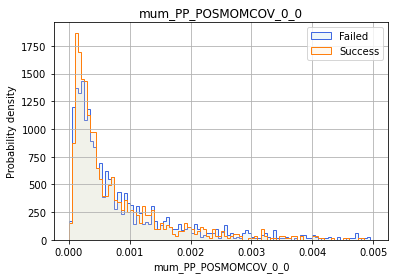

In [15]:
featureToPlot = 'mum_PP_POSMOMCOV_0_0'
featureLabel = 'mum_PP_POSMOMCOV_0_0'
featureTitle = 'mum_PP_POSMOMCOV_0_0'
binNumber = 100
boundaries = (0,.005)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

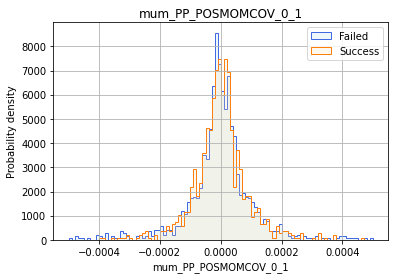

In [16]:
featureToPlot = 'mum_PP_POSMOMCOV_0_1'
featureLabel = 'mum_PP_POSMOMCOV_0_1'
featureTitle = 'mum_PP_POSMOMCOV_0_1'
binNumber = 100
boundaries = (-.0005,.0005)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

In [17]:
df_MC['mum_PP_POSMOMCOV_0_2'].value_counts()

0.0    2987
Name: mum_PP_POSMOMCOV_0_2, dtype: int64

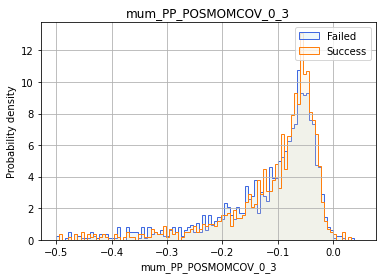

In [69]:
featureToPlot = 'mum_PP_POSMOMCOV_0_3'
featureLabel = 'mum_PP_POSMOMCOV_0_3'
featureTitle = 'mum_PP_POSMOMCOV_0_3'
binNumber = 100
boundaries = (-.5,.05)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

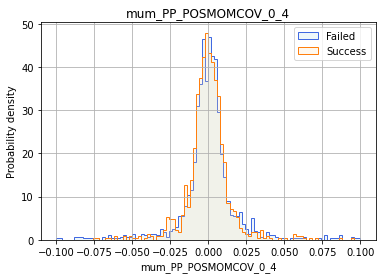

In [19]:
featureToPlot = 'mum_PP_POSMOMCOV_0_4'
featureLabel = 'mum_PP_POSMOMCOV_0_4'
featureTitle = 'mum_PP_POSMOMCOV_0_4'
binNumber = 100
boundaries = (-.1,.1)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

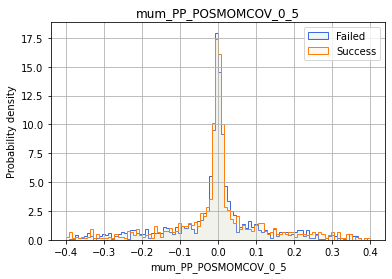

In [20]:
featureToPlot = 'mum_PP_POSMOMCOV_0_5'
featureLabel = 'mum_PP_POSMOMCOV_0_5'
featureTitle = 'mum_PP_POSMOMCOV_0_5'
binNumber = 100
boundaries = (-.4,.4)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

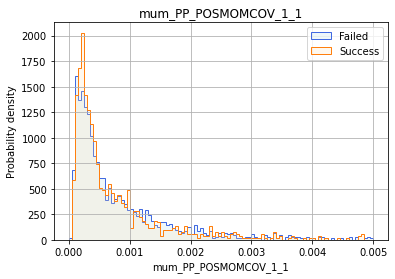

In [21]:
featureToPlot = 'mum_PP_POSMOMCOV_1_1'
featureLabel = 'mum_PP_POSMOMCOV_1_1'
featureTitle = 'mum_PP_POSMOMCOV_1_1'
binNumber = 100
boundaries = (0,.005)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

In [22]:
df_MC['mum_PP_POSMOMCOV_1_2'].value_counts()

0.0    2987
Name: mum_PP_POSMOMCOV_1_2, dtype: int64

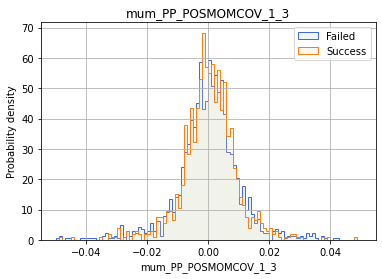

In [23]:
featureToPlot = 'mum_PP_POSMOMCOV_1_3'
featureLabel = 'mum_PP_POSMOMCOV_1_3'
featureTitle = 'mum_PP_POSMOMCOV_1_3'
binNumber = 100
boundaries = (-.05,.05)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

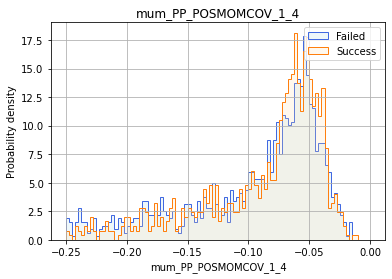

In [24]:
featureToPlot = 'mum_PP_POSMOMCOV_1_4'
featureLabel = 'mum_PP_POSMOMCOV_1_4'
featureTitle = 'mum_PP_POSMOMCOV_1_4'
binNumber = 100
boundaries = (-.25,0)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

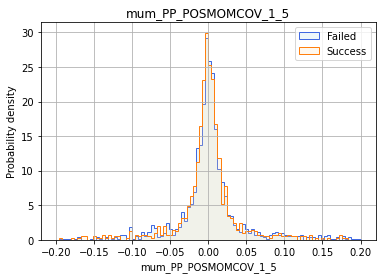

In [25]:
featureToPlot = 'mum_PP_POSMOMCOV_1_5'
featureLabel = 'mum_PP_POSMOMCOV_1_5'
featureTitle = 'mum_PP_POSMOMCOV_1_5'
binNumber = 100
boundaries = (-.2,.2)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

In [26]:
df_MC['mum_PP_POSMOMCOV_2_2'].value_counts()

0.0    2987
Name: mum_PP_POSMOMCOV_2_2, dtype: int64

In [27]:
df_MC['mum_PP_POSMOMCOV_2_3'].value_counts()

0.0    2987
Name: mum_PP_POSMOMCOV_2_3, dtype: int64

In [28]:
df_MC['mum_PP_POSMOMCOV_2_4'].value_counts()

0.0    2987
Name: mum_PP_POSMOMCOV_2_4, dtype: int64

In [29]:
df_MC['mum_PP_POSMOMCOV_2_5'].value_counts()

0.0    2987
Name: mum_PP_POSMOMCOV_2_5, dtype: int64

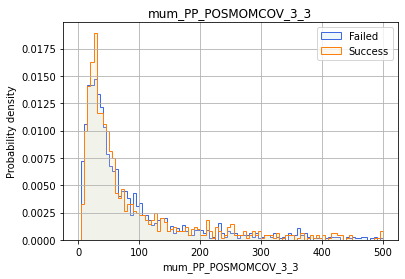

In [30]:
featureToPlot = 'mum_PP_POSMOMCOV_3_3'
featureLabel = 'mum_PP_POSMOMCOV_3_3'
featureTitle = 'mum_PP_POSMOMCOV_3_3'
binNumber = 100
boundaries = (0,500)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

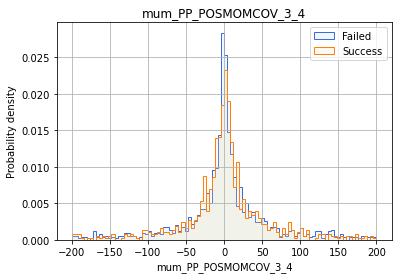

In [31]:
featureToPlot = 'mum_PP_POSMOMCOV_3_4'
featureLabel = 'mum_PP_POSMOMCOV_3_4'
featureTitle = 'mum_PP_POSMOMCOV_3_4'
binNumber = 100
boundaries = (-200,200)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

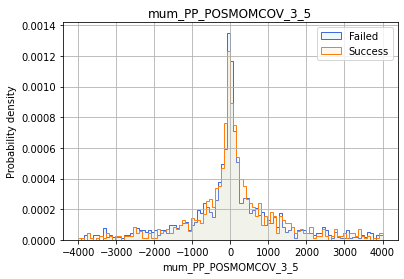

In [32]:
featureToPlot = 'mum_PP_POSMOMCOV_3_5'
featureLabel = 'mum_PP_POSMOMCOV_3_5'
featureTitle = 'mum_PP_POSMOMCOV_3_5'
binNumber = 100
boundaries = (-4000,4000)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

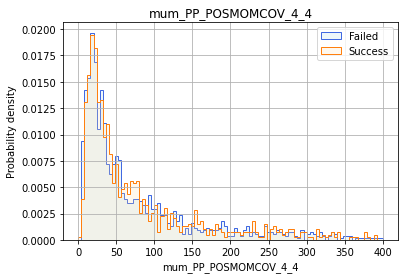

In [33]:
featureToPlot = 'mum_PP_POSMOMCOV_4_4'
featureLabel = 'mum_PP_POSMOMCOV_4_4'
featureTitle = 'mum_PP_POSMOMCOV_4_4'
binNumber = 100
boundaries = (0,400)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

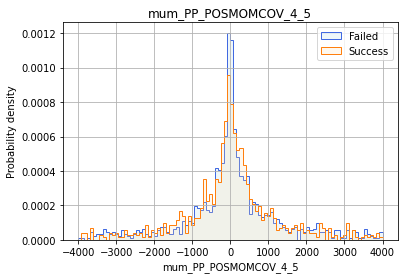

In [34]:
featureToPlot = 'mum_PP_POSMOMCOV_4_5'
featureLabel = 'mum_PP_POSMOMCOV_4_5'
featureTitle = 'mum_PP_POSMOMCOV_4_5'
binNumber = 100
boundaries = (-4000,4000)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

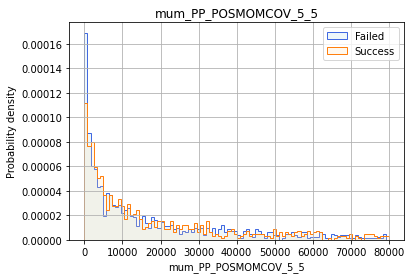

In [35]:
featureToPlot = 'mum_PP_POSMOMCOV_5_5'
featureLabel = 'mum_PP_POSMOMCOV_5_5'
featureTitle = 'mum_PP_POSMOMCOV_5_5'
binNumber = 100
boundaries = (0,80000)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

# $\pi^-$

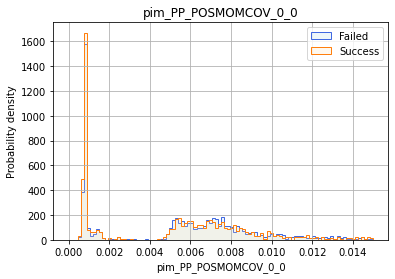

In [70]:
featureToPlot = 'pim_PP_POSMOMCOV_0_0'
featureLabel = 'pim_PP_POSMOMCOV_0_0'
featureTitle = 'pim_PP_POSMOMCOV_0_0'
binNumber = 100
boundaries = (-.0,.015)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

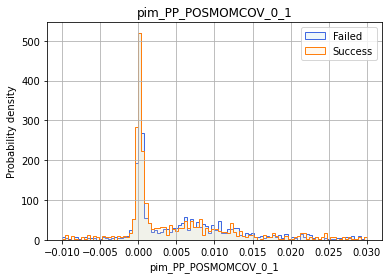

In [77]:
featureToPlot = 'pim_PP_POSMOMCOV_0_1'
featureLabel = 'pim_PP_POSMOMCOV_0_1'
featureTitle = 'pim_PP_POSMOMCOV_0_1'
binNumber = 100
boundaries = (-.01,.03)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

In [38]:
df_MC['pim_PP_POSMOMCOV_0_2'].value_counts()

0.0    2987
Name: pim_PP_POSMOMCOV_0_2, dtype: int64

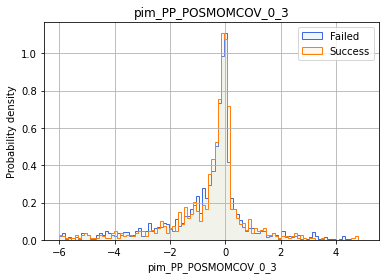

In [39]:
featureToPlot = 'pim_PP_POSMOMCOV_0_3'
featureLabel = 'pim_PP_POSMOMCOV_0_3'
featureTitle = 'pim_PP_POSMOMCOV_0_3'
binNumber = 100
boundaries = (-6,5)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

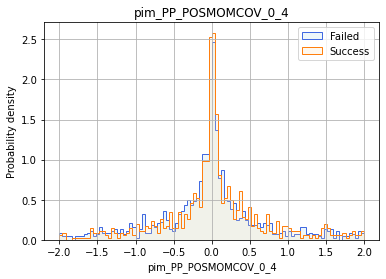

In [40]:
featureToPlot = 'pim_PP_POSMOMCOV_0_4'
featureLabel = 'pim_PP_POSMOMCOV_0_4'
featureTitle = 'pim_PP_POSMOMCOV_0_4'
binNumber = 100
boundaries = (-2,2)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

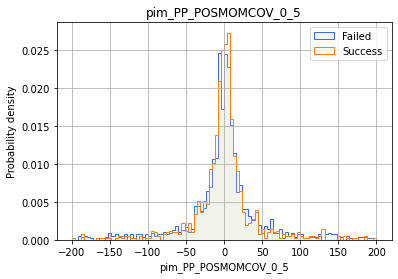

In [41]:
featureToPlot = 'pim_PP_POSMOMCOV_0_5'
featureLabel = 'pim_PP_POSMOMCOV_0_5'
featureTitle = 'pim_PP_POSMOMCOV_0_5'
binNumber = 100
boundaries = (-200,200)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

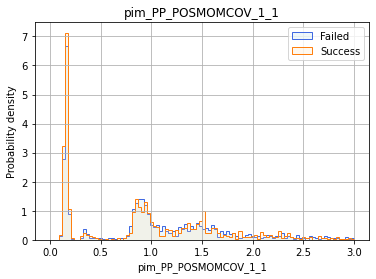

In [42]:
featureToPlot = 'pim_PP_POSMOMCOV_1_1'
featureLabel = 'pim_PP_POSMOMCOV_1_1'
featureTitle = 'pim_PP_POSMOMCOV_1_1'
binNumber = 100
boundaries = (0,3)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

In [43]:
df_MC['pim_PP_POSMOMCOV_1_2'].value_counts()

0.0    2987
Name: pim_PP_POSMOMCOV_1_2, dtype: int64

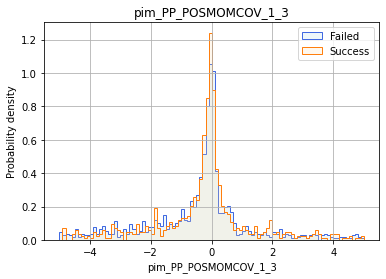

In [44]:
featureToPlot = 'pim_PP_POSMOMCOV_1_3'
featureLabel = 'pim_PP_POSMOMCOV_1_3'
featureTitle = 'pim_PP_POSMOMCOV_1_3'
binNumber = 100
boundaries = (-5,5)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

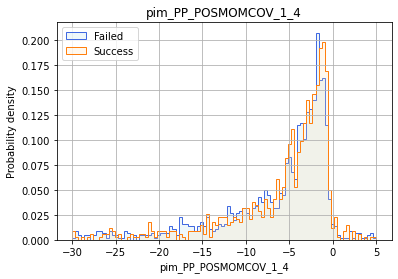

In [45]:
featureToPlot = 'pim_PP_POSMOMCOV_1_4'
featureLabel = 'pim_PP_POSMOMCOV_1_4'
featureTitle = 'pim_PP_POSMOMCOV_1_4'
binNumber = 100
boundaries = (-30,5)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend(loc=2)
plt.show()

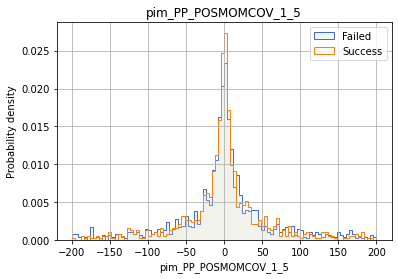

In [46]:
featureToPlot = 'pim_PP_POSMOMCOV_1_5'
featureLabel = 'pim_PP_POSMOMCOV_1_5'
featureTitle = 'pim_PP_POSMOMCOV_1_5'
binNumber = 100
boundaries = (-200,200)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

In [47]:
df_MC['pim_PP_POSMOMCOV_2_2'].value_counts()

0.0    2987
Name: pim_PP_POSMOMCOV_2_2, dtype: int64

In [48]:
df_MC['pim_PP_POSMOMCOV_2_3'].value_counts()

0.0    2987
Name: pim_PP_POSMOMCOV_2_3, dtype: int64

In [49]:
df_MC['pim_PP_POSMOMCOV_2_4'].value_counts()

0.0    2987
Name: pim_PP_POSMOMCOV_2_4, dtype: int64

In [50]:
df_MC['pim_PP_POSMOMCOV_2_5'].value_counts()

0.0    2987
Name: pim_PP_POSMOMCOV_2_5, dtype: int64

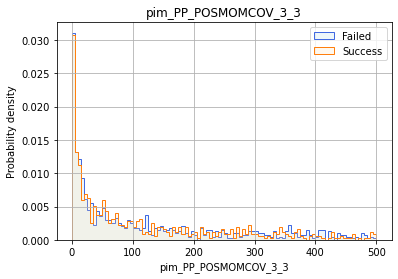

In [51]:
featureToPlot = 'pim_PP_POSMOMCOV_3_3'
featureLabel = 'pim_PP_POSMOMCOV_3_3'
featureTitle = 'pim_PP_POSMOMCOV_3_3'
binNumber = 100
boundaries = (0,500)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

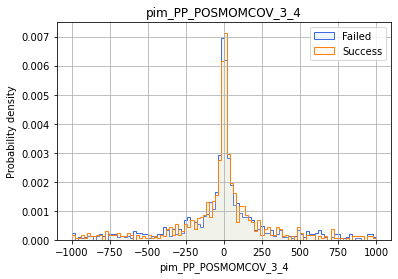

In [52]:
featureToPlot = 'pim_PP_POSMOMCOV_3_4'
featureLabel = 'pim_PP_POSMOMCOV_3_4'
featureTitle = 'pim_PP_POSMOMCOV_3_4'
binNumber = 100
boundaries = (-1000,1000)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

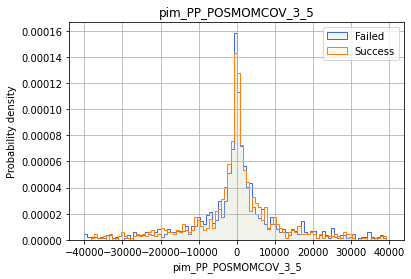

In [53]:
featureToPlot = 'pim_PP_POSMOMCOV_3_5'
featureLabel = 'pim_PP_POSMOMCOV_3_5'
featureTitle = 'pim_PP_POSMOMCOV_3_5'
binNumber = 100
boundaries = (-40000,40000)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

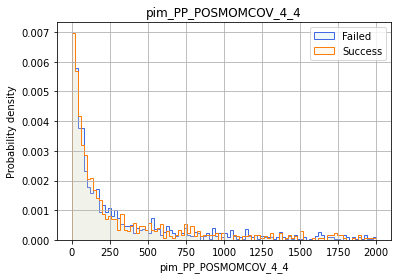

In [59]:
featureToPlot = 'pim_PP_POSMOMCOV_4_4'
featureLabel = 'pim_PP_POSMOMCOV_4_4'
featureTitle = 'pim_PP_POSMOMCOV_4_4'
binNumber = 100
boundaries = (0,2000)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

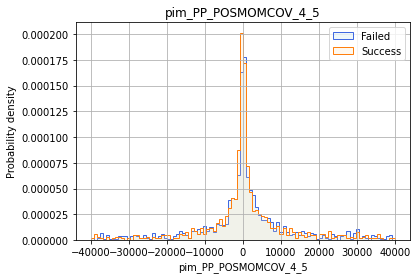

In [60]:
featureToPlot = 'pim_PP_POSMOMCOV_4_5'
featureLabel = 'pim_PP_POSMOMCOV_4_5'
featureTitle = 'pim_PP_POSMOMCOV_4_5'
binNumber = 100
boundaries = (-40000,40000)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()

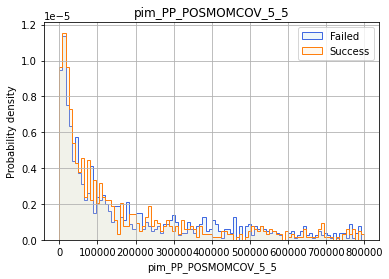

In [64]:
featureToPlot = 'pim_PP_POSMOMCOV_5_5'
featureLabel = 'pim_PP_POSMOMCOV_5_5'
featureTitle = 'pim_PP_POSMOMCOV_5_5'
binNumber = 100
boundaries = (0,800000)
yscale = 'linear'
normalized = True

if normalized:
    ylabel = 'Probability density'
else:
    ylabel = 'Events'

plt.hist(
    df_MC_Failed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    label='Failed',
    density=normalized
)

plt.hist(
    df_MC_Reconstructed[featureToPlot],
    range=boundaries, bins=binNumber,
    histtype='stepfilled',
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    edgecolor='tab:orange',
    label='Success',
    density=normalized
)

plt.xlabel(featureLabel)
plt.ylabel(ylabel)
plt.yscale(yscale)
plt.grid()
plt.title(featureTitle)
plt.legend()
plt.show()